# Decision Tree
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using Decision Tree to classify the data points on the target ("Outcome" of the stop and search).

In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, roc_auc_score

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [50]:
def evaluate(model, X_train, y_train, X_test, y_test, average='weighted', binary=False):
    print(f"Accurancy Score (Train): {int(np.around(model.score(X_train, y_train), 2) * 100)}%")
    print(f"Accuracy Score (Test): {int(np.around(model.score(X_test, y_test), 2) * 100)}%")
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    print(f"\nPrecision Score (Train): {int(np.around(precision_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Precision Score (Test): {int(np.around(precision_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nRecall Score (Train): {int(np.around(recall_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Recall Score (Test): {int(np.around(recall_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nF1 Score (Train): {int(np.around(f1_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"F1 Score (Test): {int(np.around(f1_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nMCC (Train): {matthews_corrcoef(y_train, y_train_predictions)}")
    print(f"MCC (Test): {matthews_corrcoef(y_test, y_test_predictions)}")
    print("\n Confusion Matrix")
    if binary:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=["No Action", "Action"])
    else:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions)

## Cleaning the Data set

In [51]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values

In [52]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split the data into train and test

In [53]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## Train the Decision Tree

In [54]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Accurancy Score (Train): 99%
Accuracy Score (Test): 54%

Precision Score (Train): 99%
Precision Score (Test): 54%

Recall Score (Train): 99%
Recall Score (Test): 54%

F1 Score (Train): 99%
F1 Score (Test): 54%

MCC (Train): 0.9768761494426926
MCC (Test): 0.11258529565141523

 Confusion Matrix


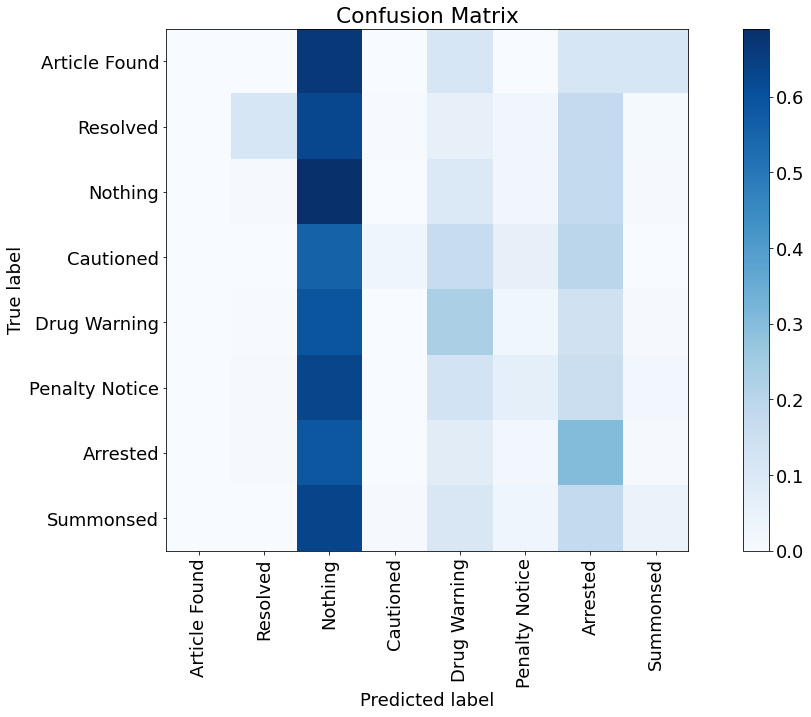

In [55]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Large discrepency between the training score and testing score indicates large overfitting of the data, I will prune the data.

## Prune and visualisation

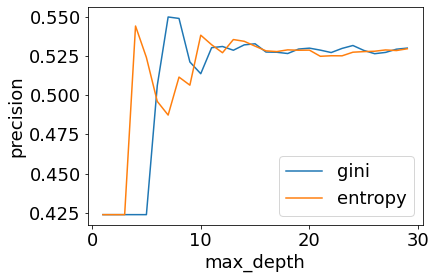

In [56]:
#Simple function to run our model using different values for max_depth (from 1 to 30) and visualise its results to see how the precision differs for each value.
#Visualisation technique from: https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752


max_depth = []
precision_gini = []
precision_entropy = []
for i in range(1,30):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 precision_gini.append(precision_score(y_test, pred, average='weighted'))
 ####
 dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 precision_entropy.append(precision_score(y_test, pred, average='weighted'))
 ####
 max_depth.append(i)
d = pd.DataFrame({'precision_gini':pd.Series(precision_gini), 
 'precision_entropy':pd.Series(precision_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','precision_gini', data=d, label='gini')
plt.plot('max_depth','precision_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('precision')
plt.legend()

It seems like in this scenario gini and entropy both work best for larger trees, but gini has a higher peak for smaller trees. So let’s first draw the tree with max_depth=6 and criterion=gini to see how it looks like.

In [57]:
ptree = DecisionTreeClassifier(criterion='gini', max_depth=6)
ptree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 66%
Accuracy Score (Test): 65%

Precision Score (Train): 63%
Precision Score (Test): 51%

Recall Score (Train): 66%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.03103203442310589
MCC (Test): 0.009789287268286732

 Confusion Matrix


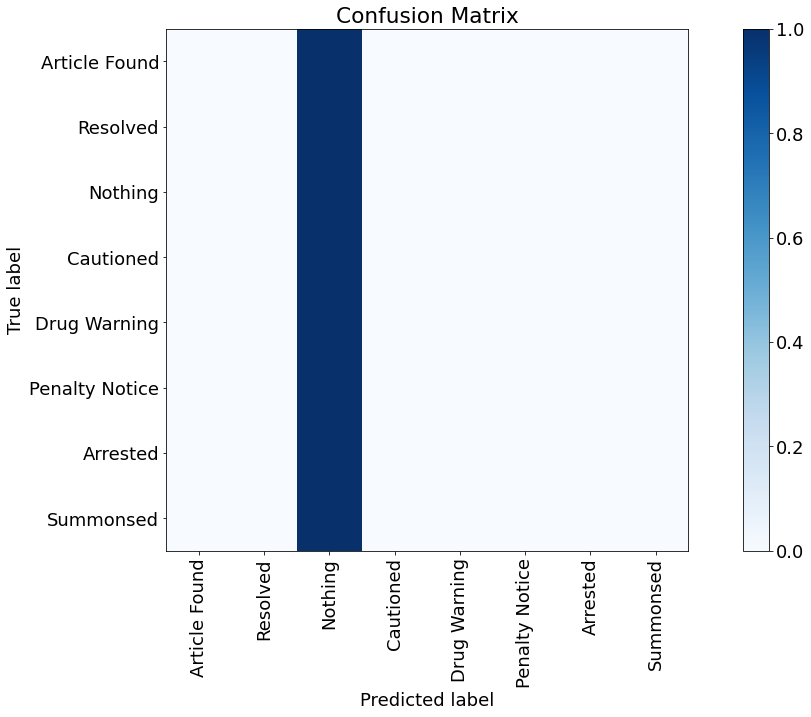

In [58]:
evaluate(model=ptree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

The Decision Tree appears to be very biased towards predicting Nothing. I will try the more stable max_depth of 20.

In [59]:
ptree = DecisionTreeClassifier(criterion='gini', max_depth=20)
ptree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 75%
Accuracy Score (Test): 62%

Precision Score (Train): 79%
Precision Score (Test): 53%

Recall Score (Train): 75%
Recall Score (Test): 62%

F1 Score (Train): 70%
F1 Score (Test): 55%

MCC (Train): 0.46027422549452784
MCC (Test): 0.07553268913779661

 Confusion Matrix


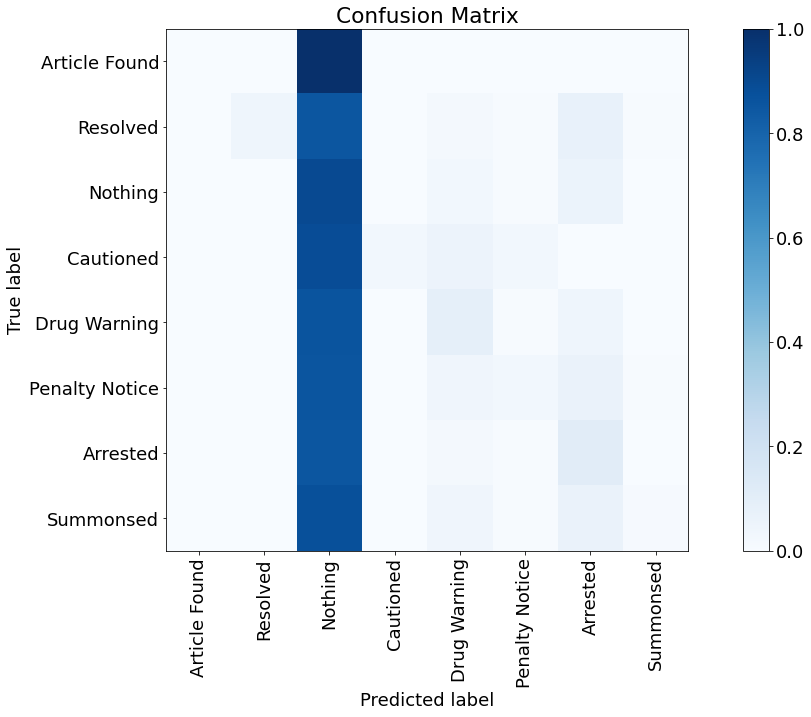

In [60]:
evaluate(model=ptree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Much better precision score but still appears to be biased to predicting Nothing.

## Preprocessing

In [61]:
#Preprocessing technique from Exercise 2 Part 2
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [62]:
#Preproccesing technique from lecture 2 to normalise the data
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [63]:
tree_std = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree_std.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 66%
Accuracy Score (Test): 65%

Precision Score (Train): 63%
Precision Score (Test): 51%

Recall Score (Train): 66%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.03103203442310589
MCC (Test): 0.009789287268286732

 Confusion Matrix


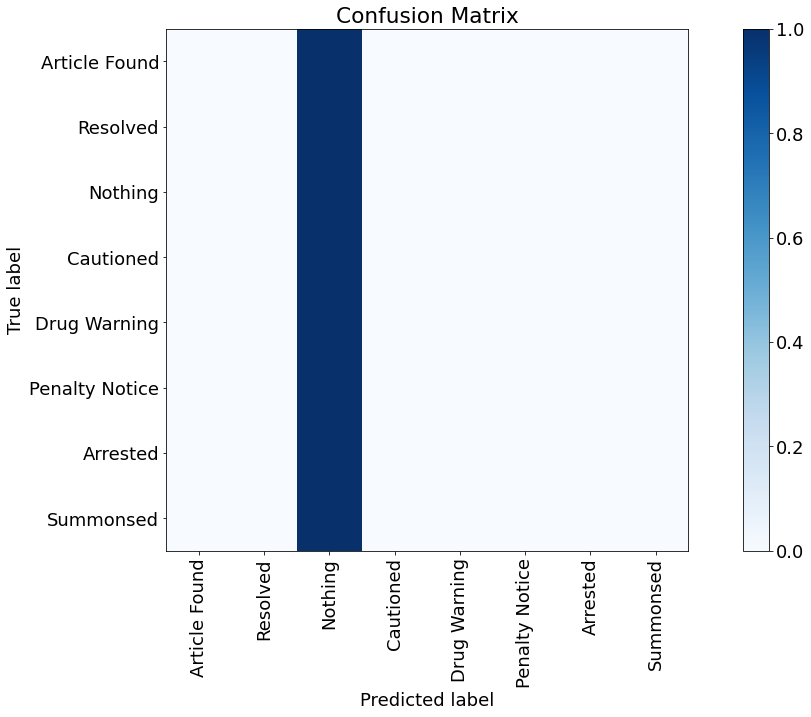

In [64]:
evaluate(model=tree_std, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

In [65]:
tree_std = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree_std.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 75%
Accuracy Score (Test): 62%

Precision Score (Train): 79%
Precision Score (Test): 53%

Recall Score (Train): 75%
Recall Score (Test): 62%

F1 Score (Train): 70%
F1 Score (Test): 55%

MCC (Train): 0.46239787127665166
MCC (Test): 0.07577057060917032

 Confusion Matrix


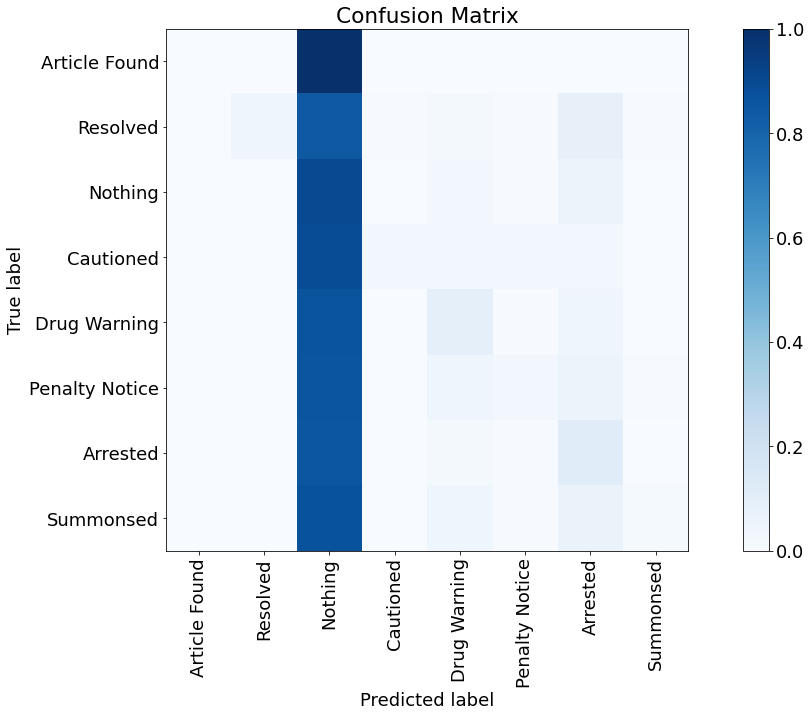

In [66]:
evaluate(model=tree_std, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Both decision trees are identical ones with the same hyperparameters and no preprocessing. I will try K-Fold instead.

## Training Using K-Fold Cross Validation

In [67]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
tree_kfold = DecisionTreeClassifier(criterion='gini', max_depth=6)
util.k_fold_train(model=tree_kfold, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6540815642083375
Accuracy (Test): 0.6540815642083375
Precision (Train): 0.6143223114541451
Precision (Test): 0.6143223114541451
MCC (Train): 0.015255120501874426
MCC (Test): 0.015255120501874426

Fold #2, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6554314652714894
Accuracy (Test): 0.6554314652714894
Precision (Train): 0.608499077792287
Precision (Test): 0.608499077792287
MCC (Train): 0.013004725477743893
MCC (Test): 0.013004725477743893

Fold #3, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.653905490156622
Accuracy (Test): 0.653905490156622
Precision (Train): 0.607577848653247
Precision (Test): 0.607577848653247
MCC (Train): 0.012152276817904425
MCC (Test): 0.012152276817904425

Fold #4, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6546349397994433
Accuracy (Test): 0.6546349397994433
Precision

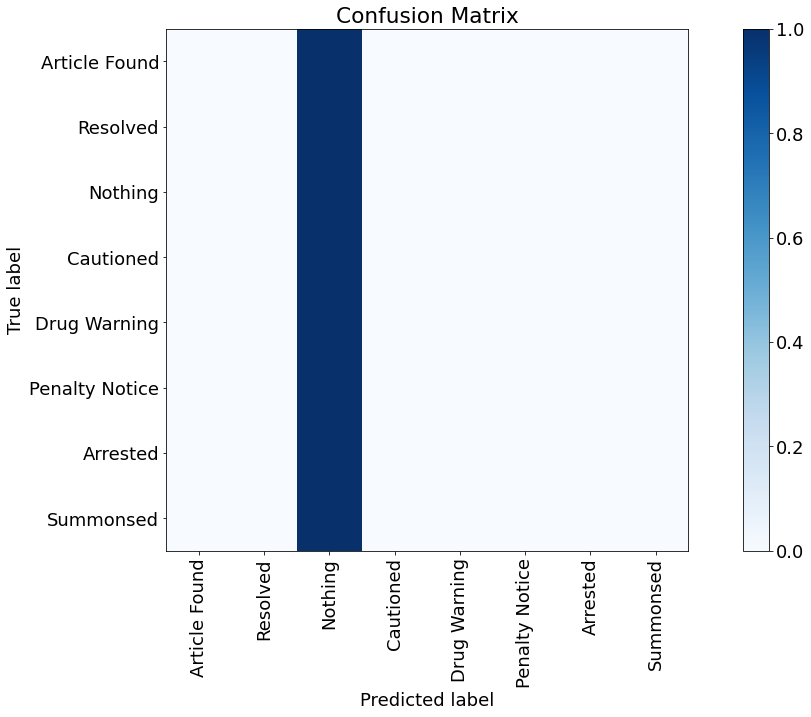

In [68]:
y_predict_k = tree_kfold.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k)

In [ ]:
tree_kfold = DecisionTreeClassifier(criterion='gini', max_depth=20)
util.k_fold_train(model=tree_kfold, data=k_fold_data)

In [ ]:
y_predict_k = tree_kfold.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k)

## Using SMOTE
We use SMOTE to even out the unbalanced datasetm should I use the preprocessed data?

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


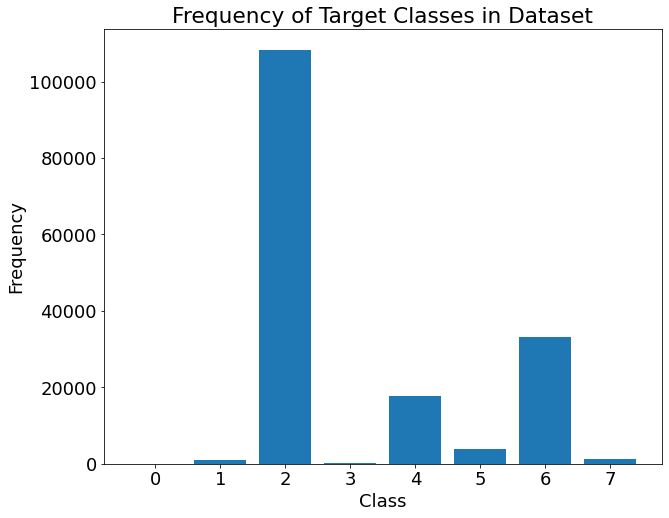

In [69]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


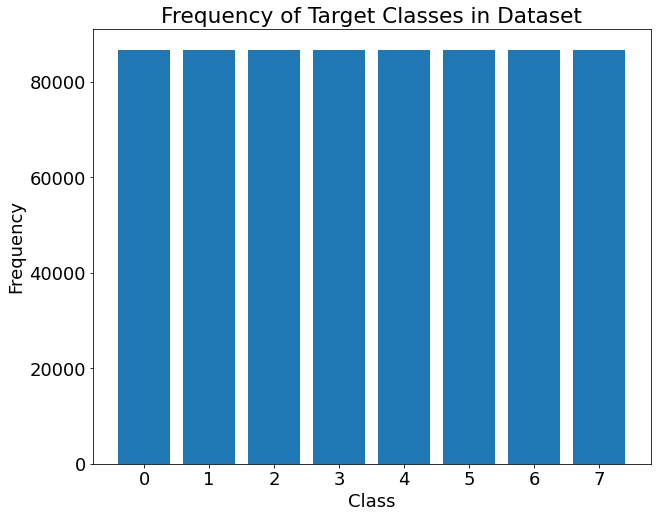

In [70]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
usm.display_frequencies(y_smote)

In [71]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 9%
Accuracy Score (Test): 9%

Precision Score (Train): 53%
Precision Score (Test): 59%

Recall Score (Train): 9%
Recall Score (Test): 9%

F1 Score (Train): 6%
F1 Score (Test): 6%

MCC (Train): 0.0516951536588875
MCC (Test): 0.049381225545412244

 Confusion Matrix


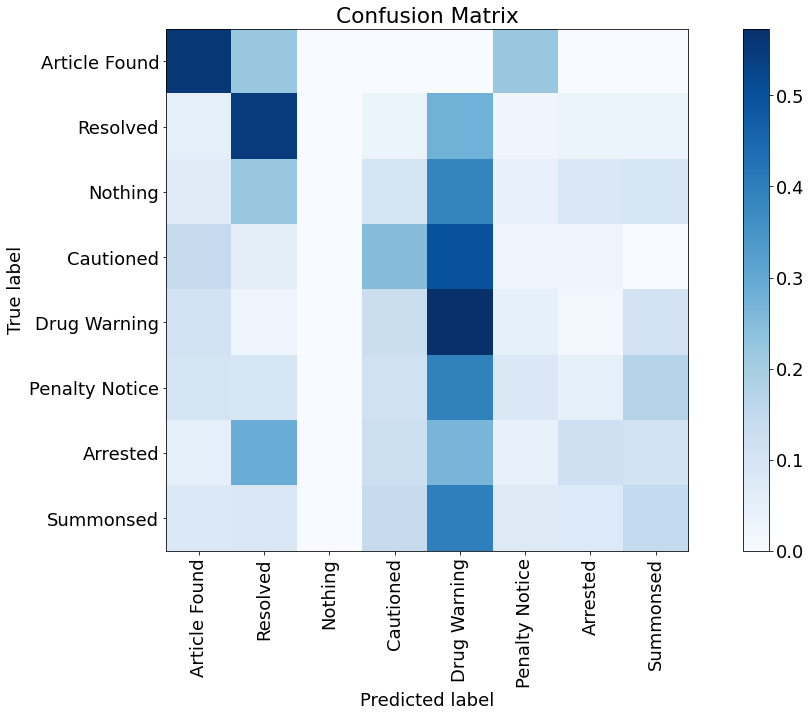

In [72]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

In [73]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 47%
Accuracy Score (Test): 28%

Precision Score (Train): 74%
Precision Score (Test): 53%

Recall Score (Train): 47%
Recall Score (Test): 28%

F1 Score (Train): 53%
F1 Score (Test): 34%

MCC (Train): 0.32243052040381587
MCC (Test): 0.07440466760894536

 Confusion Matrix


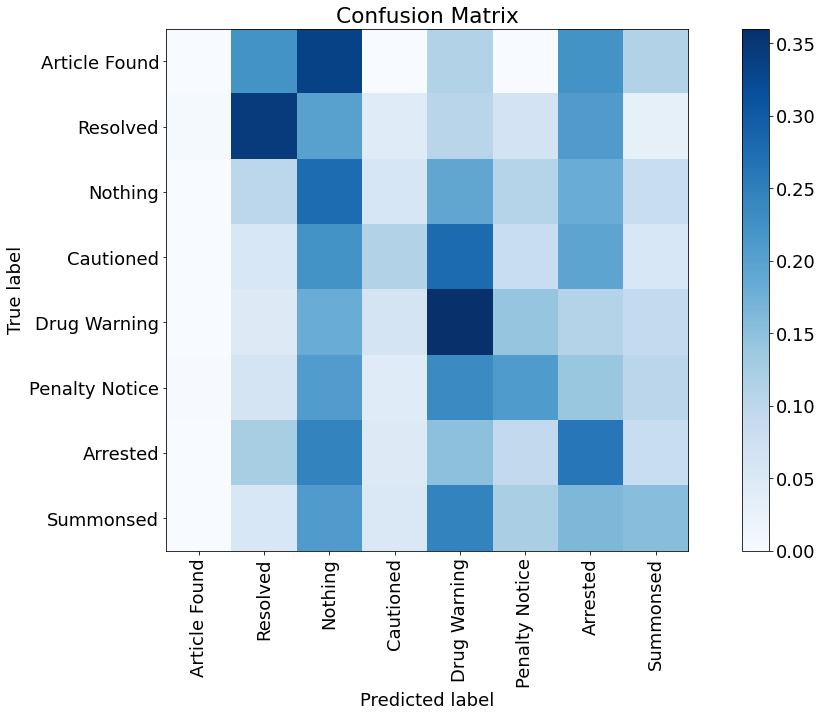

In [74]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Most well balanced confusion matrix so far,and good precision score.

## Using Biased SMOTE
We over sample minority classes, but not to an extent that equalizes them to the majority class

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


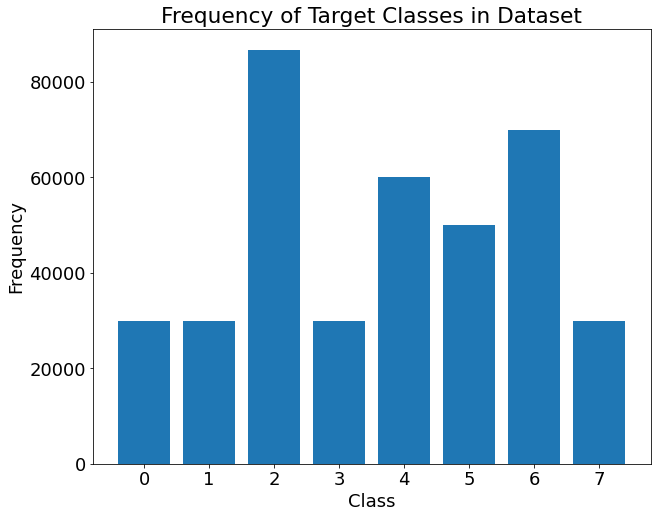

In [75]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [76]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 33%
Accuracy Score (Test): 33%

Precision Score (Train): 52%
Precision Score (Test): 52%

Recall Score (Train): 33%
Recall Score (Test): 33%

F1 Score (Train): 37%
F1 Score (Test): 37%

MCC (Train): 0.08253654255296065
MCC (Test): 0.08169129666312049

 Confusion Matrix


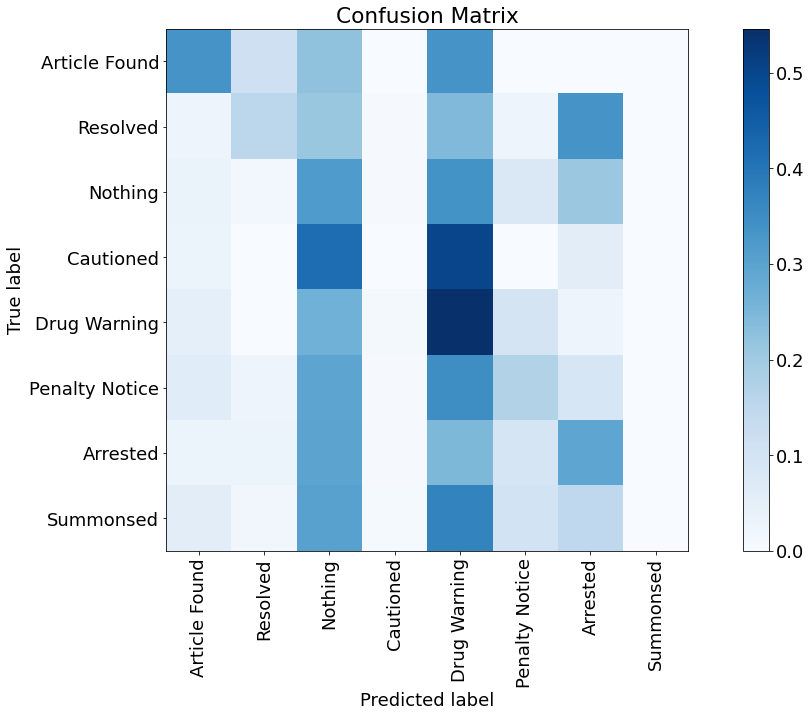

In [77]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

This yields identical confusion matrix and results as without biased SMOTE.

In [78]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 57%
Accuracy Score (Test): 40%

Precision Score (Train): 70%
Precision Score (Test): 53%

Recall Score (Train): 57%
Recall Score (Test): 40%

F1 Score (Train): 62%
F1 Score (Test): 44%

MCC (Train): 0.3649141115027248
MCC (Test): 0.0915141704940351

 Confusion Matrix


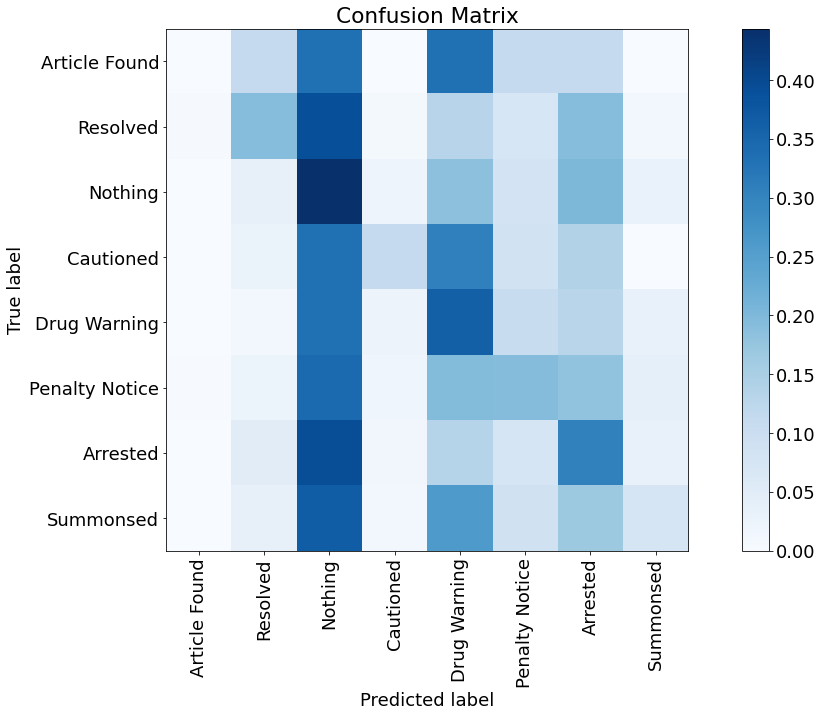

In [79]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Slightly less balanced compared to the model with using just SMOTE.

## Bootstrap Aggregating

In [80]:
bagging = BaggingClassifier()
bagging.fit(X_train, y_train)

BaggingClassifier()

Accurancy Score (Train): 95%
Accuracy Score (Test): 57%

Precision Score (Train): 95%
Precision Score (Test): 54%

Recall Score (Train): 95%
Recall Score (Test): 57%

F1 Score (Train): 95%
F1 Score (Test): 56%

MCC (Train): 0.9073983578541605
MCC (Test): 0.11105204696073585

 Confusion Matrix


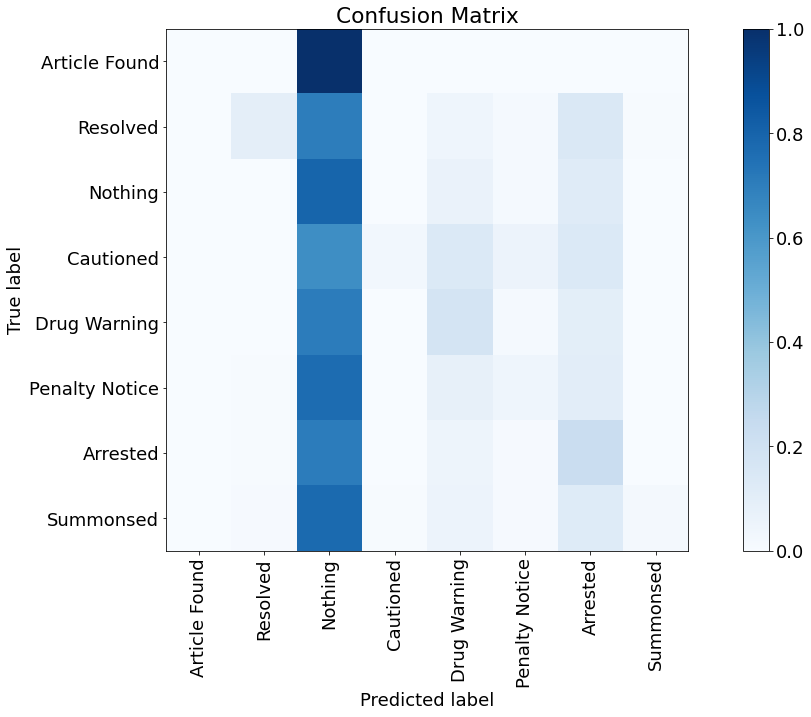

In [81]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Very similar results to the raw decision tree, rather than pruning and using K-Fold, I will go straight to using the same SMOTE process as I did for the decision tree.

In [82]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 96%
Accuracy Score (Test): 44%

Precision Score (Train): 96%
Precision Score (Test): 54%

Recall Score (Train): 96%
Recall Score (Test): 44%

F1 Score (Train): 96%
F1 Score (Test): 48%

MCC (Train): 0.9166195260598995
MCC (Test): 0.10487134834323109

 Confusion Matrix


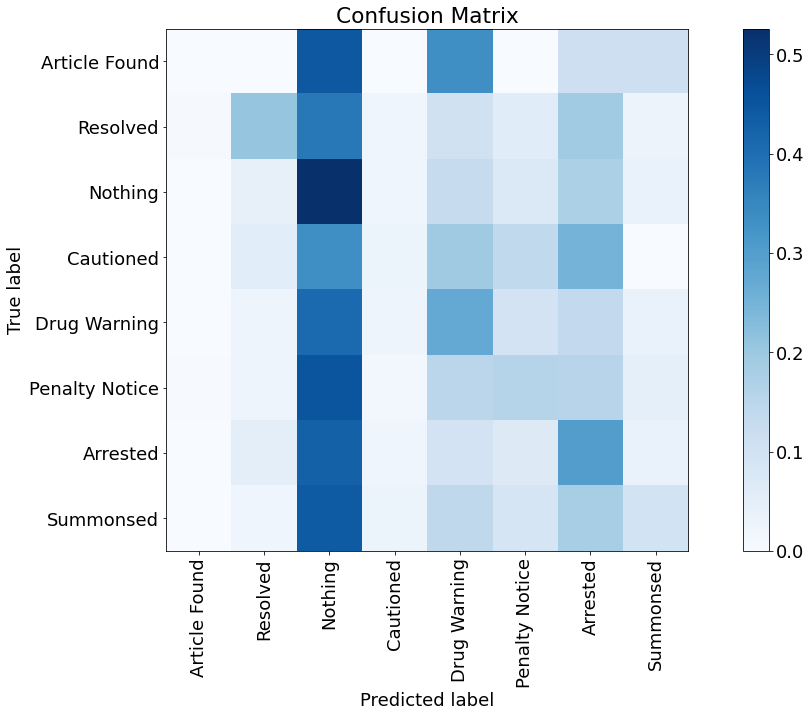

In [83]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Much more balanced confusion matrix, however there still appears to be oversampling. Perhaps Biased SMOTE will solve this.

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


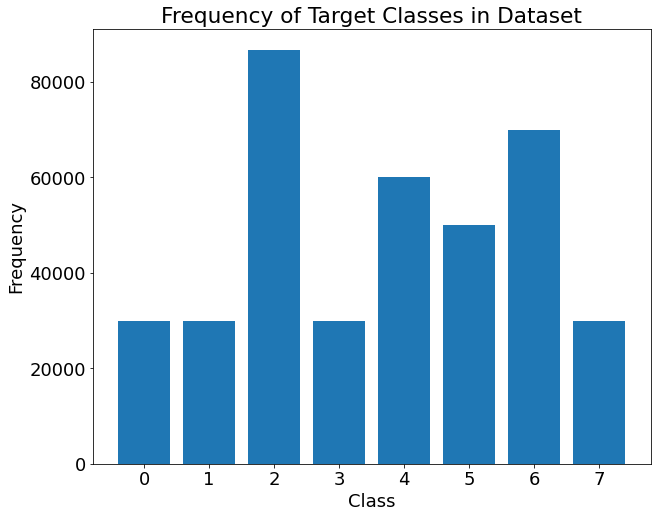

In [84]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [85]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 96%
Accuracy Score (Test): 44%

Precision Score (Train): 96%
Precision Score (Test): 54%

Recall Score (Train): 96%
Recall Score (Test): 44%

F1 Score (Train): 96%
F1 Score (Test): 48%

MCC (Train): 0.9158023435188091
MCC (Test): 0.10489589797555156

 Confusion Matrix


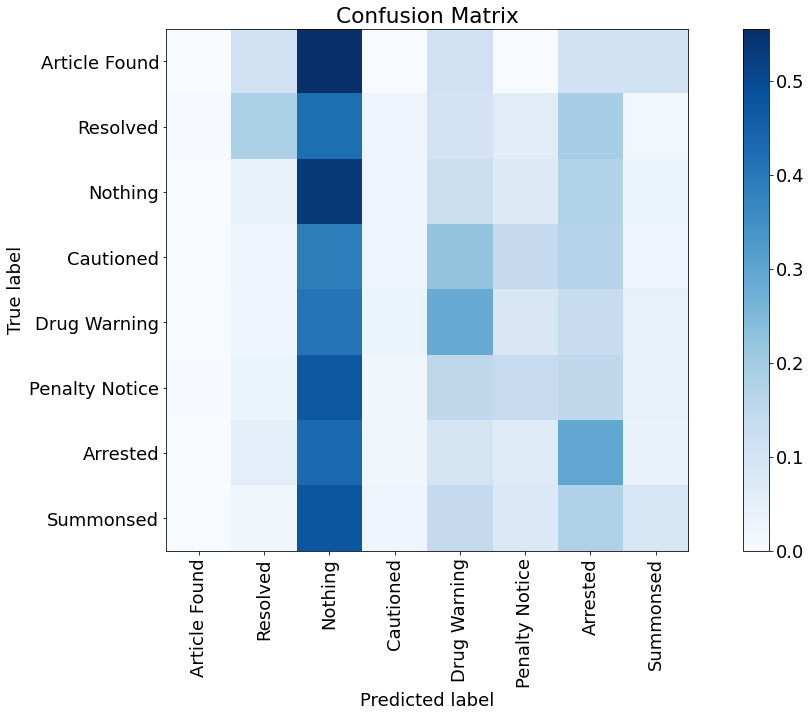

In [86]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Model is very biased towards predicting arrested as an outcome. I will lower the frequency of class six.

Class 0: 8.65%     (30000)
Class 1: 8.65%     (30000)
Class 2: 25.03%     (86784)
Class 3: 8.65%     (30000)
Class 4: 17.3%     (60000)
Class 5: 14.42%     (50000)
Class 6: 8.65%     (30000)
Class 7: 8.65%     (30000)
Total: 346784


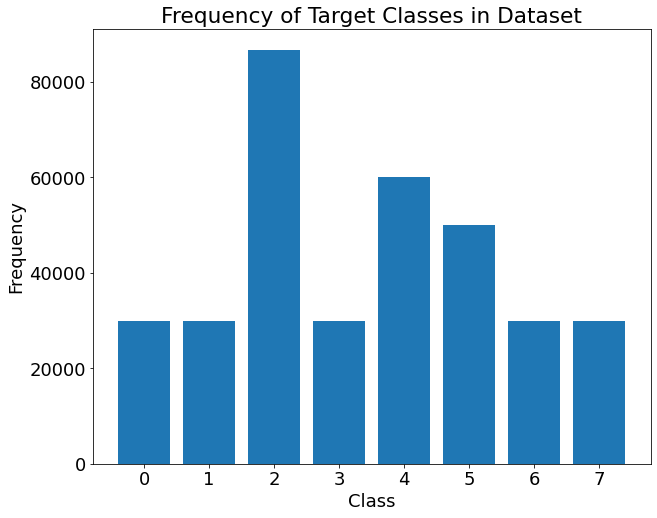

In [87]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:30000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [88]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 95%
Accuracy Score (Test): 46%

Precision Score (Train): 96%
Precision Score (Test): 55%

Recall Score (Train): 95%
Recall Score (Test): 46%

F1 Score (Train): 95%
F1 Score (Test): 49%

MCC (Train): 0.9050437945676139
MCC (Test): 0.10354322360743401

 Confusion Matrix


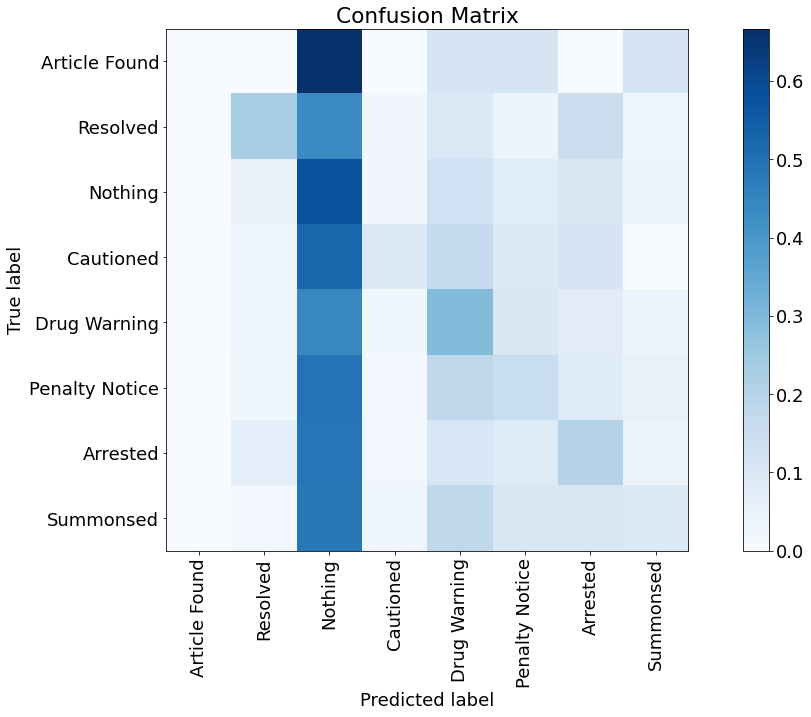

In [89]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Slightly better confusion matrix

## Random Forests

[0.5215501879319636, 0.5245049201609376, 0.5262591866312268, 0.5289622778341341, 0.5344131616484105, 0.5308111769850696, 0.5296202039797642, 0.5312882885456445, 0.5348211084392445, 0.5344719000851729, 0.5345691215000578, 0.5348478286885664, 0.5365322111582773, 0.5385448259038917, 0.5362575900866348, 0.5379056385655144, 0.5370407559672734, 0.5360517132970151, 0.5371471830578897, 0.5361979554003318, 0.5377142552721736, 0.5393623348540236, 0.5376308740674275, 0.5364453662782643, 0.5376135977045007, 0.5360832410495783, 0.5367306972572919, 0.53529354363622, 0.5378294158173917, 0.5382202395726698, 0.5386651508754159, 0.5380546664158288, 0.5358516068316771, 0.5375774613085483, 0.5362172824461211, 0.5364367291648071, 0.5379971944265592, 0.5362261909725639, 0.5378712511534729, 0.5366939061927647, 0.5381998188533047, 0.5373394000713293, 0.5375441782464049, 0.5376558462584939, 0.5373499785562806, 0.5377485720687982, 0.5360401406870553, 0.537901113288632, 0.5379969438024957, 0.5380912812174257, 0.

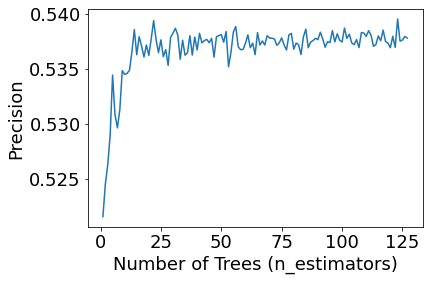

In [90]:
# Investigates the accuracy over a range of estimators plotting the result
# Same function used in exercise 5 part 2
precision_data = []
nums = []
for i in range(1,128):
    rf_model = RandomForestClassifier(n_estimators=i,criterion="entropy")
    rf_model.fit(X_train, y_train)
    y_model = rf_model.predict(X_test)
    precision = precision_score(y_test, y_model, average='weighted')
    precision_data.append(precision)
    nums.append(i)
    
print(precision_data)
plt.plot(nums,precision_data)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Precision")
plt.show()

The graph indicates that the most stable precision occurs at around 100 n_estimators, which is the default.

In [91]:
f_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=127)

Accurancy Score (Train): 99%
Accuracy Score (Test): 57%

Precision Score (Train): 99%
Precision Score (Test): 54%

Recall Score (Train): 99%
Recall Score (Test): 57%

F1 Score (Train): 99%
F1 Score (Test): 56%

MCC (Train): 0.9767837633382264
MCC (Test): 0.1120915398891279

 Confusion Matrix


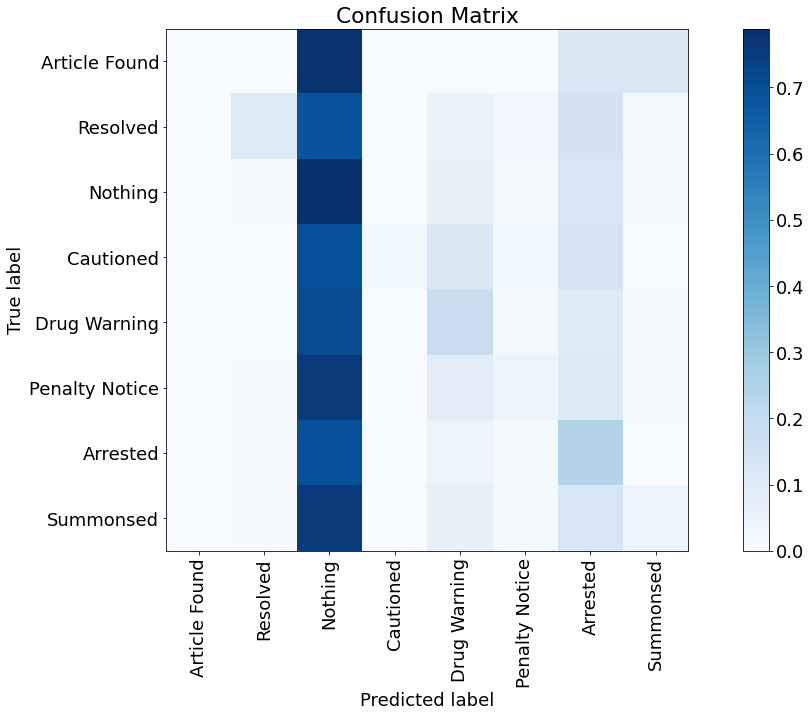

In [92]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Similarly to Bagging, I shall use SMOTE to reduce the overfitting and balance the confusion matrix.

In [93]:
rf_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy')

Accurancy Score (Train): 99%
Accuracy Score (Test): 46%

Precision Score (Train): 99%
Precision Score (Test): 55%

Recall Score (Train): 99%
Recall Score (Test): 46%

F1 Score (Train): 99%
F1 Score (Test): 50%

MCC (Train): 0.9766415500571382
MCC (Test): 0.10550236173702421

 Confusion Matrix


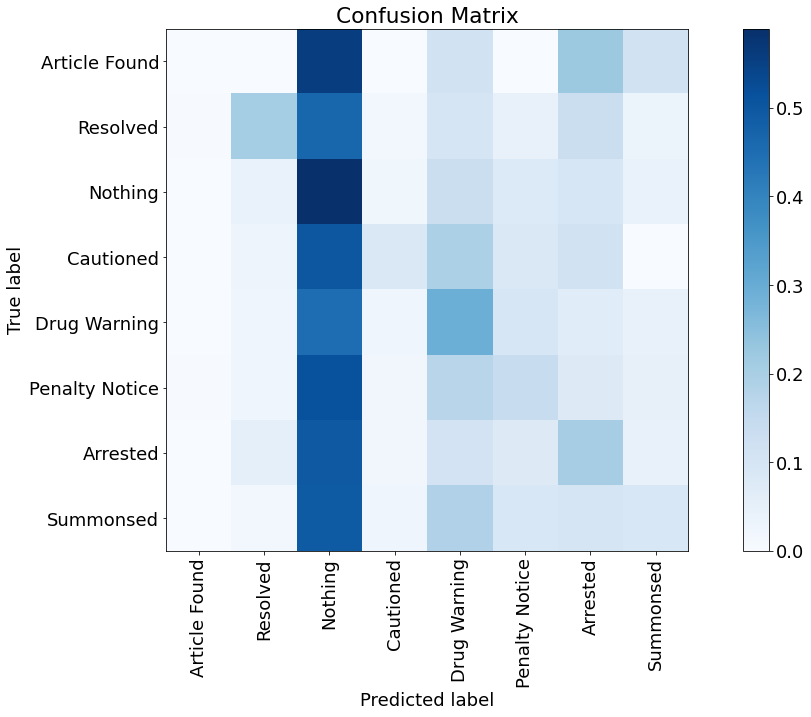

In [94]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

This model produces very good evaluation scores, but once again the confusion matrix isn't as balanced as the Decision Tree matrix

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


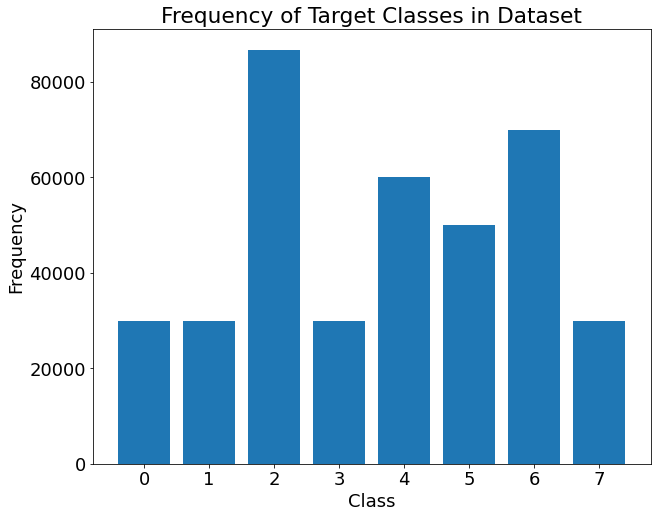

In [96]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [97]:
rf_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy')

In [98]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Accurancy Score (Train): 99%
Accuracy Score (Test): 44%


## Using Grid Search to Tune Hyperparamaters
The most well balanced confusion matrix out of all the tree models was the first Decision Tree using smoting, so I will use Grid Search on a Decision Tree.

In [335]:
X_smote, y_smote = usm.smote_data(X_train, y_train)

In [336]:
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
decision_tree_search = GridSearchCV(DecisionTreeClassifier(), tree_param, verbose=1, cv=3, scoring="precision_weighted", n_jobs=-1)
decision_tree_search.fit(X_smote, y_smote)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.8min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring='precision_weighted', verbose=1)

Accurancy Score (Train): 87%
Accuracy Score (Test): 38%

Precision Score (Train): 92%
Precision Score (Test): 55%

Recall Score (Train): 87%
Recall Score (Test): 38%

F1 Score (Train): 89%
F1 Score (Test): 44%

 Confusion Matrix


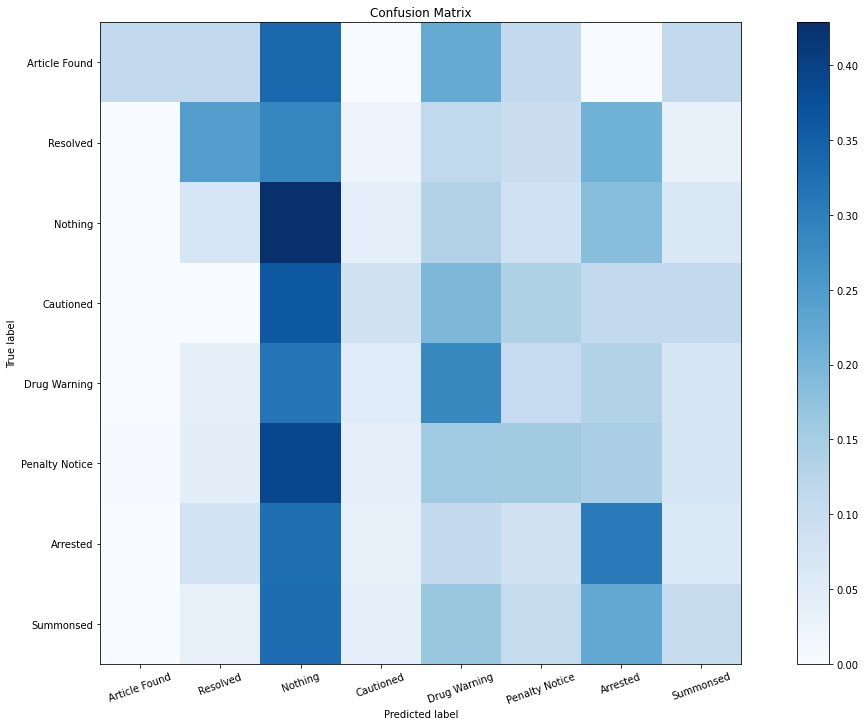

In [341]:
evaluate(model=decision_tree_search.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

In [340]:
print(decision_tree_search.best_params_)

{'criterion': 'gini', 'max_depth': 30}


A balanced confusion matrix but not as balanced as the smoted Decision Tree with max depth twenty, appears to be that Grid Search looks for best precision rather than balanced matrix.